# Generating IC's

In [13]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import cosmax

## Matching an Arbitrary Power Spectrum

We start by generating some white noise $n(\mathbf{x})$. Hence we sample it from a random normal distribution.

In [14]:
size = 1.0 # Mpc/h
n_grid = 128
n_grid_half = n_grid // 2
key, noise_key = jax.random.split(jax.random.PRNGKey(0))
rho = jax.random.normal(noise_key, (n_grid, n_grid, n_grid), dtype=jnp.float32) 

# volume of the box
V = float(size ** 3)
# volume of each grid cell
Vx = V / n_grid ** 3
rho = rho / jnp.sqrt(Vx)

We now define a power spectrum, later we will transform the white noise such that it matches the desired power spectrum.

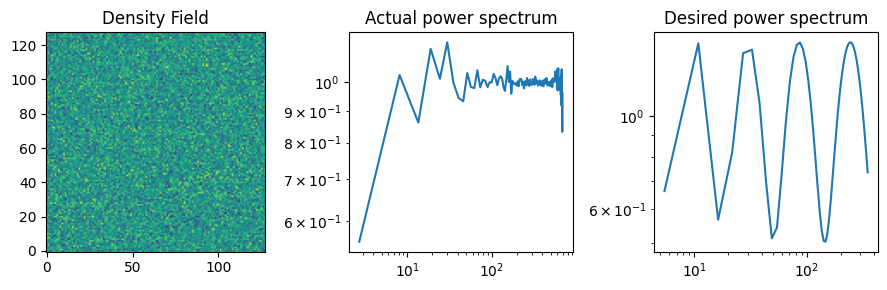

In [ ]:
delta = rho

power_spectrum = cosmax.PowerSpectrum(elements = n_grid, bins=n_grid)

k, Pk = power_spectrum(rho)


# lets define a desired power spectrum
k_desired = power_spectrum.bin_edges
Pk_desired = (jnp.sin(jnp.log(k_desired)*6)*0.5 + 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(delta[n_grid//2], origin='lower')
ax1.set_title('Density Field')
ax2.plot(k, Pk)
ax2.set_title('Actual power spectrum')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.plot(k_desired[:n_grid_half], Pk_desired[:n_grid_half])
ax3.set_title('Desired power spectrum')
ax3.set_xscale('log')
ax3.set_yscale('log')

plt.tight_layout()


According to Pen et al. (1997), we need to compute the correlation Kernel

$$ 
A(k) = \sqrt{P(k)}.
$$

Then we can convolve the white noise with the correlation Kernel in furier space to generate the density field with the desired power spectrum.

$$
\delta(\mathbf{k}) = n(\mathbf{k}) A(\mathbf{k}).
$$

source : [INITIAL CONDITIONS FOR LARGE COSMOLOGICAL SIMULATIONS](https://arxiv.org/pdf/0804.3536)


There is one confusing aspect to this, as we are looking for 3D correlation Kernel, however our power spectrum is a scalar dimensional function of distance. However we simply generate a correlation kernel, where the the real valued variable k is defined as $k = \sqrt{\mathbf{k}_x^2 + \mathbf{k}_y^2 + \mathbf{k}_z^2}$. Hence a more accurate defintion would be:

$$
A(\mathbf{k}) = \sqrt{P(\langle \mathbf{k} \rangle)}
$$

In [16]:
# lets compute the correlation Kernel
Ax_lin = jnp.sqrt(Pk_desired)

# assign the values
Ax = Ax_lin.at[power_spectrum.index_grid].get()
Ax = jnp.fft.ifftshift(Ax)

# transform to fourier space
delta_k = jnp.fft.rfftn(delta)

# apply correlation kernel
delta_k_corr = delta_k * Ax
# shift back
delta_k_corr = jnp.fft.ifftshift(delta_k_corr)
# transform back to real space
delta_corr = jnp.fft.irfftn(delta_k_corr).real

Now that we have computed all the values, let us examine the noise, before and after the correlation kernel was applied, and the correlation kernel in furier space.

Text(0.5, 1.0, 'Correlation Kernel')

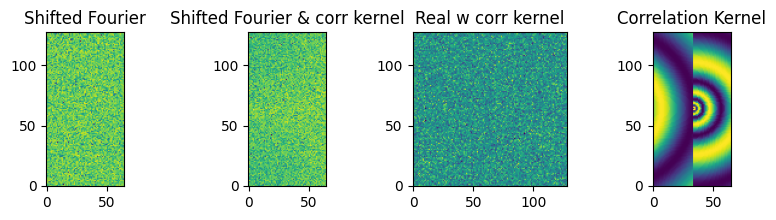

In [17]:

# plot delta_k
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 2))

ax1.imshow(jnp.log10(jnp.abs(delta_k[n_grid//2])), origin='lower')
ax1.set_title('Shifted Fourier')

ax2.imshow(jnp.log10(jnp.abs(delta_k_corr[n_grid//2])), origin='lower')
ax2.set_title('Shifted Fourier & corr kernel')

ax3.imshow(delta_corr[n_grid//2], origin='lower')
ax3.set_title('Real w corr kernel')

ax4.imshow(Ax[n_grid//2], origin='lower')
ax4.set_title('Correlation Kernel')

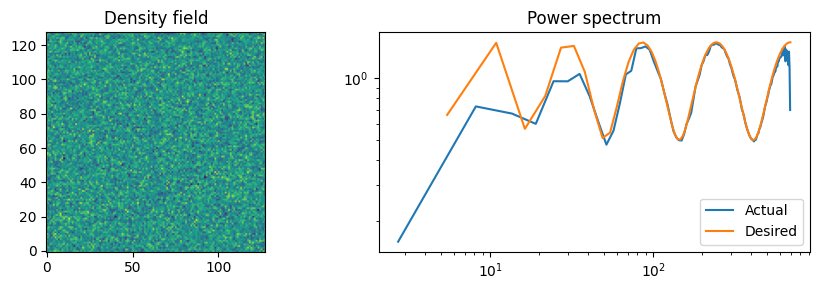

In [19]:
k, Pk = power_spectrum(delta_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.imshow(delta_corr[n_grid_half], origin='lower')
ax1.set_title('Density field')
ax2.plot(k, Pk, label='Actual') 
ax2.set_title('Power spectrum')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(k_desired, Pk_desired, label='Desired')
ax2.legend()
plt.tight_layout()